# Strut force and earth pressures

In this script we analyse strut force and earth pressures data that were collected on the instrumented construction site in Alpnachstad. 

**Input:**

*   a csv-file '`rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv`'. It contains the data automatically collected with the Catman software. This file is constructed partially by hand, partially with the help of two python scripts (they are not available on Google Colab, only on the BFH server).
*   a csv-file '`rawdata_Klima_aussen.csv`'. It contains the climate data (temperature, humidity, etc.) ouside the box where all the electronics where stored. This data is used to investigate the temperature effects.

**Output:**

*   none. This Jupyter-Notebook is dedicated to exploratory data analysis only. 

In [ ]:
#test_flag_colab
from google.colab import drive
drive.mount('/content/drive')

# working directory: drive/MyDrive/spundsteif
%cd '/content/drive/MyDrive/spundsteif'

%load_ext autoreload
%autoreload 2

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/spundsteif


# Import the libraries

In [ ]:
import pandas as pd
import numpy as np
import io
import csv
from datetime import datetime, date, timedelta

from google.colab import files

from copy import copy

import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn import linear_model

import re

# Import the data

## Read the Catman data

In [ ]:
CATMAN_FILE_NAME = './data/rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv'
df_catman = pd.read_csv(CATMAN_FILE_NAME, delimiter=';')
#print(df_catman)
#print(df_catman.columns)

# important note: one column has mistakenly been labelled 'EV31'. In reality it measured the strain gauge EH31

cols = ['EH31', 'EV31']
df_catman = df_catman.assign(E = df_catman[cols].sum(1)).drop(cols, 1)
df_catman.rename(columns = {'E':'EH31'}, inplace = True)
print(df_catman)
print(df_catman.columns)

# covert the column 'Zeit' into python datetime objects and sort in chronological order

for index, row in df_catman.iterrows():
    df_catman.at[index, 'Zeit'] = datetime.strptime(df_catman.at[index, 'Zeit'], '%d.%m.%Y %H:%M')

df_catman = df_catman.sort_values('Zeit', ascending=True)

<ipython-input-3-aeb11365cd94>:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df_catman = df_catman.assign(E = df_catman[cols].sum(1)).drop(cols, 1)


      Unnamed: 0         EDSA          EDSB         EDSC  EDSD          EDSE  \
0              0  -7687.31982  2.179666e+06 -35919.26172   NaN  1.226793e+04   
1              1  -7719.16553  2.169327e+06 -35989.06641   NaN  1.233930e+04   
2              2  -7820.88623  2.159840e+06 -36016.18750   NaN  1.243958e+04   
3              3    183.08820  1.934437e+06 -20862.70313   NaN  1.955401e+04   
4              4  -8862.40723  1.705553e+06 -26351.51563   NaN  1.095719e+04   
...          ...          ...           ...          ...   ...           ...   
1885        1885 -63382.89844 -2.563729e+04          NaN   NaN -4.819262e+06   
1886        1886 -58923.52344 -2.356395e+04          NaN   NaN -4.824424e+06   
1887        1887 -44199.95703 -1.748341e+04          NaN   NaN -4.816859e+06   
1888        1888 -29251.58594 -1.084607e+04          NaN   NaN -4.816321e+06   
1889        1889 -24097.75977 -8.154800e+03          NaN   NaN -4.816772e+06   

           EDSF         EDSG     Tempa 

## Read the climate data

In [ ]:
KLIMA_AUSSEN_FILE_NAME = './data/rawdata_Klima_aussen.csv'
df_klima = pd.read_csv(KLIMA_AUSSEN_FILE_NAME, delimiter=';')

# covert the column 'Aufnahmezeit' into python datetime objects and sort them in chronological order: 
for index, row in df_klima.iterrows():
    df_klima.at[index, 'Aufnahmezeit'] = datetime.strptime(df_klima.at[index, 'Aufnahmezeit'], '%d.%m.%Y  %H:%M')

df_klima = df_klima.sort_values('Aufnahmezeit', ascending=True)
df_klima = df_klima.drop(columns='Unnamed: 0', axis=1)

print(df_klima)
print(df_klima.columns)

             Aufnahmezeit  Temperatur  Relative Luftfeuchtigkeit  Taupunkt
0     2021-07-14 11:44:00        26.3                       41.5     12.19
1     2021-07-14 12:14:00        24.8                       49.9     13.64
2     2021-07-14 12:44:00        24.0                       50.9     13.21
3     2021-07-14 13:14:00        21.3                       56.3     12.25
4     2021-07-14 13:44:00        21.0                       61.2     13.25
...                   ...         ...                        ...       ...
6410  2022-04-12 03:01:00         4.3                       80.6      1.27
6411  2022-04-12 04:01:00         3.9                       82.6      1.22
6412  2022-04-12 05:01:00         3.6                       83.8      1.12
6413  2022-04-12 06:01:00         4.8                       82.3      2.05
6414  2022-04-12 07:01:00         7.8                       75.3      3.71

[6415 rows x 4 columns]
Index(['Aufnahmezeit', 'Temperatur', 'Relative Luftfeuchtigkeit', 'Taupunkt

## Read Plaxis data

In [ ]:
# This file contains the active earth pressures acting on the sheet pile wall 
# for varying reduction factors. The different construction phases were not 
# investigated. This dataframe concerns the last construction stage only. 

PLAXIS_ERDDRUCK = './data/Plaxis_EB_Erddruck_aktiv.csv'
df_erddruck = pd.read_csv(PLAXIS_ERDDRUCK, delimiter=';')

print(df_erddruck)
print(df_erddruck.columns)

    Point_01  Length_[m]_01  X_coordinate_[m]_01  Y_coordinate_[m]_01  \
0        0.0           0.00                0.001                 0.50   
1        1.0           0.50                0.001                 0.00   
2        2.0           0.50                0.001                 0.00   
3        3.0           0.50                0.001                 0.00   
4        4.0           0.50                0.001                 0.00   
..       ...            ...                  ...                  ...   
85      85.0          14.05                0.001               -13.55   
86      86.0          14.05                0.001               -13.55   
87      87.0          14.05                0.001               -13.55   
88      88.0          14.50                0.001               -14.00   
89      89.0          14.50                0.001               -14.00   

    Phase_4_[kN/m2]_01  Point_02  Length_[m]_02  X_coordinate_[m]_02  \
0                -0.12       0.0           0.00    

In [ ]:
# This file contains the active earth pressures acting on the sheet pile wall 
# at each construction stage. The reduction factor was not investigated. This 
# data was obtained with beta_D = 1.0

PLAXIS_BAUPHASEN = './data/Plaxis_EB_Bauphasen.csv'
df_bauphasen = pd.read_csv(PLAXIS_BAUPHASEN, delimiter=';')

print(df_bauphasen)
print(df_bauphasen.columns)

    Point_10  Length_[m]_10  X_coordinate_[m]_10  Y_coordinate_[m]_10  \
0          0           0.00                0.001                 0.50   
1          1           0.50                0.001                 0.00   
2          2           0.50                0.001                 0.00   
3          3           0.50                0.001                 0.00   
4          4           0.50                0.001                 0.00   
..       ...            ...                  ...                  ...   
91        91          14.89                0.001               -14.39   
92        92          14.89                0.001               -14.39   
93        93          15.21                0.001               -14.71   
94        94          15.21                0.001               -14.71   
95        95          15.50                0.001               -15.00   

    Initial_phase_[kN/m2]_10  Phase_1_[kN/m2]_10  Phase_4_[kN/m2]_10  \
0                       0.00                0.00   

# Strut force

The sheet pile wall was supported by struts (double HEB 300 profiles) and stiffened with horizontal bracing (HEB 600 profile). The struts spanned from the underground garage walls to the excavation supporting system. 
Unfortunately, the struts were installed on the 07.02.2022 or on the 08.02.2022, that is, after the excavation was concluded. For this reason, we expect the strut forces to be relatively low. 

The strut force was measured by two load cells (in German "Kraftmessdosen", KMD) and a temperature sensor Temp_c was employed to compensate the temperature drift in the load cells. The unit is [kN]. Positive values indicate pressure, and negative ones indicate tension. 

The load cells were simply placed between the strut and the horizontal bracing (in German "Longarine"), and they were not bolted together with either one. This means the load cells cannot measure tension, bur rather pressure only. 

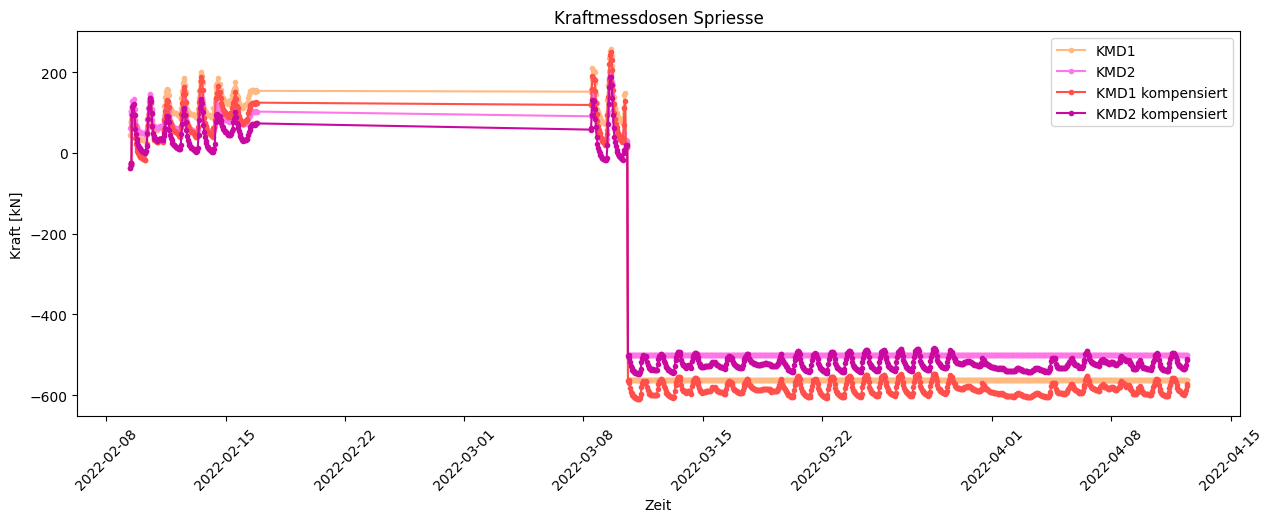

In [ ]:
# Kraftmessdosen

plt.figure(figsize=(15,5))
plt.title('Kraftmessdosen Spriesse')
plt.plot(df_catman.Zeit, df_catman.KMD1, color='#ffb982', marker='.', label = 'KMD1')
plt.plot(df_catman.Zeit, df_catman.KMD2, color='#ff76e8', marker='.', label = 'KMD2')
plt.plot(df_catman.Zeit, df_catman.KMD1kompensiert, color='#ff504c', marker='.', label = 'KMD1 kompensiert')
plt.plot(df_catman.Zeit, df_catman.KMD2kompensiert, color='#c909a0', marker='.', label = 'KMD2 kompensiert')
plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

In [ ]:
# There a significant drop in the measured strut force on the 10h of March 2022. Why?

print(df_catman.KMD1[1101:1103])
print(df_catman.Zeit[1101:1103])

1101     24.66656
1102   -563.16864
Name: KMD1, dtype: float64
1101    2022-03-10 13:44:00
1102    2022-03-10 14:44:00
Name: Zeit, dtype: object


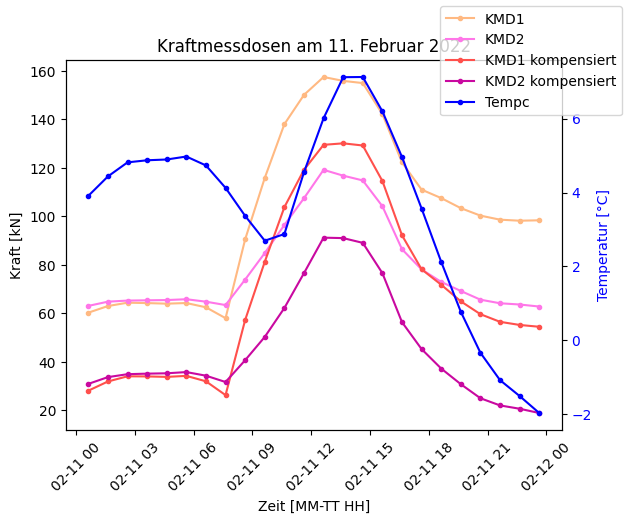

In [ ]:
# Does the strut force correlate with the outside temperature? 
# Time period before the force drops

fig, ax1 = plt.subplots()
ax1.set_title('Kraftmessdosen am 11. Februar 2022')

ax1.plot(df_catman.Zeit[909:933], df_catman.KMD1[909:933], color='#ffb982', marker='.', label = 'KMD1')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD2[909:933], color='#ff76e8', marker='.', label = 'KMD2')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD1kompensiert[909:933], color='#ff504c', marker='.', label = 'KMD1 kompensiert')
ax1.plot(df_catman.Zeit[909:933], df_catman.KMD2kompensiert[909:933], color='#c909a0', marker='.', label = 'KMD2 kompensiert')

ax1.set_xlabel('Zeit [MM-TT HH]') 
ax1.set_ylabel('Kraft [kN]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_catman.Zeit[909:933], df_catman['Tempc'][909:933],'b.-', label='Tempc')
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
fig.legend()

fig.show()

# Obviously, the strut force does show a correlation with temperature even after compensation.
# In fact, the strut expands and contracts because of the temperature variations and sun exposure 
# during the day. This effect cannot be removed by mathematical means. 

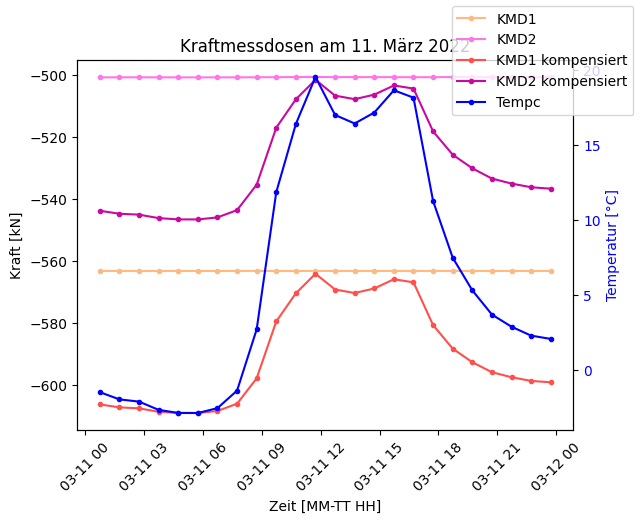

In [ ]:
# Does the strut force correlate with the outside temperature? 
# Time period after the force drops

fig, ax1 = plt.subplots()
ax1.set_title('Kraftmessdosen am 11. März 2022')

ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD1[1112:1136], color='#ffb982', marker='.', label = 'KMD1')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD2[1112:1136], color='#ff76e8', marker='.', label = 'KMD2')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD1kompensiert[1112:1136], color='#ff504c', marker='.', label = 'KMD1 kompensiert')
ax1.plot(df_catman.Zeit[1112:1136], df_catman.KMD2kompensiert[1112:1136], color='#c909a0', marker='.', label = 'KMD2 kompensiert')

ax1.set_xlabel('Zeit [MM-TT HH]') 
ax1.set_ylabel('Kraft [kN]', color = 'k') 
ax1.tick_params(axis='x', rotation=45)
ax1.tick_params(axis ='y', labelcolor = 'k') 


# Adding twin axes
ax2 = ax1.twinx()

ax2.plot(df_catman.Zeit[1112:1136], df_catman['Tempc'][1112:1136],'b.-', label='Tempc') # Tempc oder 'Temperatur aussen' ??
ax2.set_ylabel('Temperatur [°C]', color = 'blue') 
ax2.tick_params(axis ='y', labelcolor = 'blue') 
fig.legend()

fig.show()

# The raw data show a constant, negative value over time. This means either the load cell 
# has stopped working, or there is no more force acting on the strut. Remember, the load 
# cell cannot record tension.

In [ ]:
# the analysis of static behaviour focuses on the period starting from the 4th of December onwards (index 533)
strut_cols = ['Zeit', 'KMD1', 'KMD2', 'KMD1kompensiert', 'KMD2kompensiert']
df_strut = df_catman[867:][strut_cols]


# downsampling to a weekly frequency
df_strut_downsample = df_strut.resample('D', on='Zeit').mean()


# Calculate the timestamp based on index value
for index, row in df_strut_downsample.iterrows():
  df_strut_downsample.at[index, 'Zeit_timestamp'] = index.timestamp()


df_strut_downsample

,KMD1,KMD2,KMD1kompensiert,KMD2kompensiert,Zeit_timestamp
Zeit,,,,,
2022-02-09,64.272527,87.060536,17.648408,34.248911,1.644365e+09
2022-02-10,68.349015,77.011854,37.792234,46.455072,1.644451e+09
2022-02-11,101.870650,79.086090,68.807916,46.023355,1.644538e+09
2022-02-12,118.340781,77.621131,79.715651,38.996000,1.644624e+09
2022-02-13,120.598537,78.486779,85.857876,43.746117,1.644710e+09
...,...,...,...,...,...
2022-04-08,-563.123865,-500.702510,-577.731317,-515.309963,1.649376e+09
2022-04-09,-563.125256,-500.691201,-589.505355,-527.071299,1.649462e+09
2022-04-10,-563.127223,-500.716377,-584.637718,-522.226874,1.649549e+09


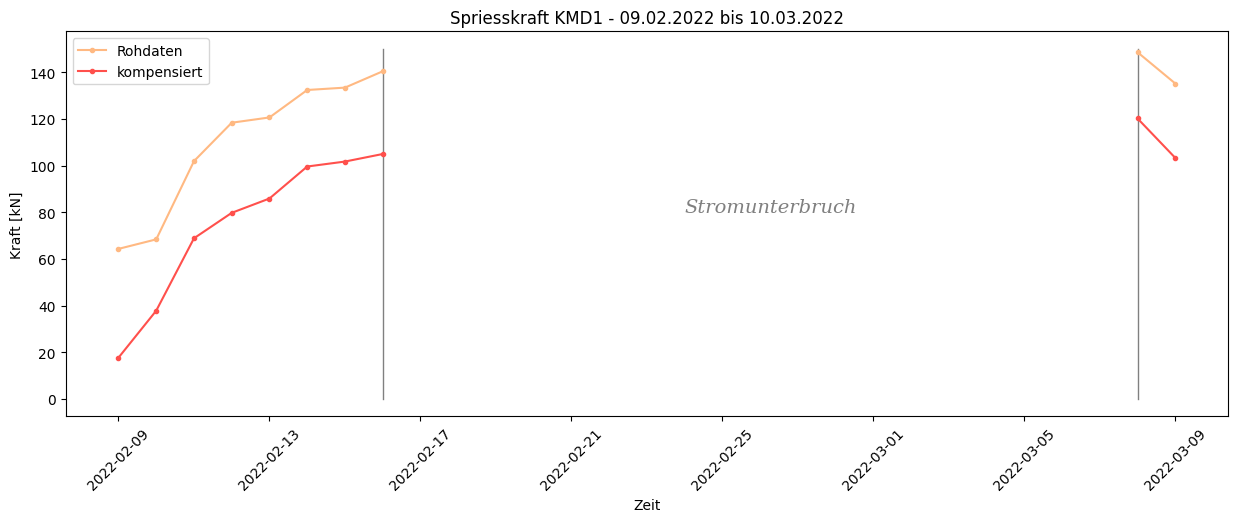

In [ ]:
# create the data needed to plot the beginning and the end of the electricity supply interruption on the graph

begin_elsupply = datetime(2022, 2, 16, 0, 0)
end_elsupply = datetime(2022, 3, 8, 0, 0)

beginx = [begin_elsupply, begin_elsupply]
beginy = [0, 150]
endx = [end_elsupply, end_elsupply]
endy = [0, 150]


plt.figure(figsize=(15,5))
plt.title('Spriesskraft KMD1 - 09.02.2022 bis 10.03.2022')

font_elsupply = {'family': 'serif', 'color': 'grey' , 'size': 14, 'style': 'italic'}
plt.text(datetime(2022, 2, 24, 0, 0), 80, 'Stromunterbruch', fontdict=font_elsupply)
plt.plot(beginx, beginy, color='grey', linewidth=1)
plt.plot(endx, endy, color='grey', linewidth=1)

plt.plot(df_strut_downsample.KMD1[0:29], color='#ffb982', marker='.', label='Rohdaten')
plt.plot(df_strut_downsample.KMD1kompensiert[0:29], color='#ff504c', marker='.', label='kompensiert')


plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

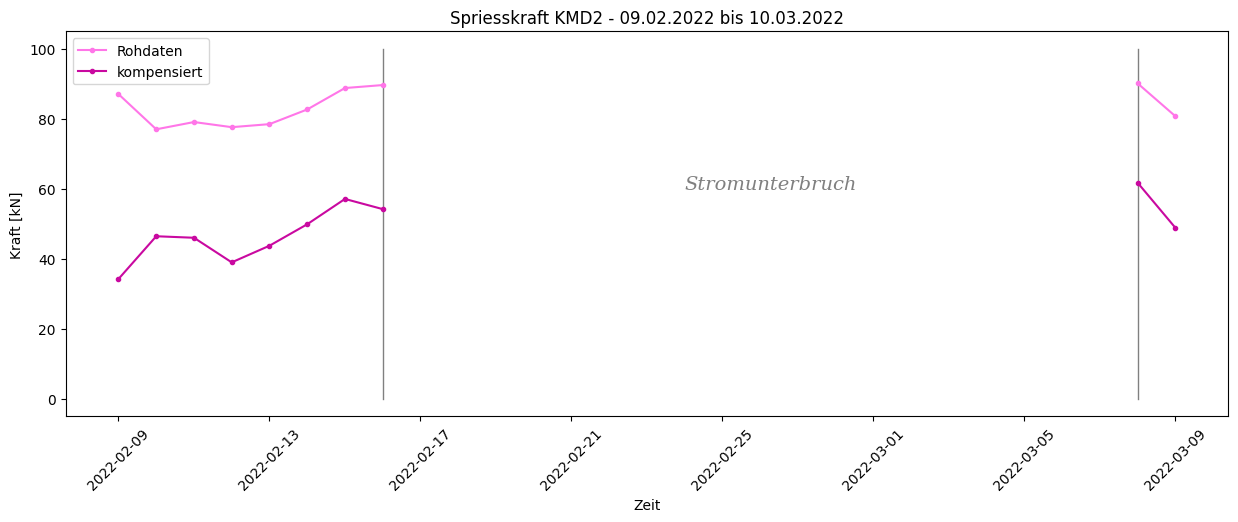

In [ ]:
# create the data needed to plot the beginning and the end of the electricity supply interruption on the graph

begin_elsupply = datetime(2022, 2, 16, 0, 0)
end_elsupply = datetime(2022, 3, 8, 0, 0)

beginx = [begin_elsupply, begin_elsupply]
beginy = [0, 100]
endx = [end_elsupply, end_elsupply]
endy = [0, 100]


plt.figure(figsize=(15,5))
plt.title('Spriesskraft KMD2 - 09.02.2022 bis 10.03.2022')

font_elsupply = {'family': 'serif', 'color': 'grey' , 'size': 14, 'style': 'italic'}
plt.text(datetime(2022, 2, 24, 0, 0), 60, 'Stromunterbruch', fontdict=font_elsupply)
plt.plot(beginx, beginy, color='grey', linewidth=1)
plt.plot(endx, endy, color='grey', linewidth=1)

plt.plot(df_strut_downsample.KMD2[0:29], color='#ff76e8', marker='.', label='Rohdaten')
plt.plot(df_strut_downsample.KMD2kompensiert[0:29], color='#c909a0', marker='.', label='kompensiert')


plt.xlabel('Zeit')
plt.ylabel('Kraft [kN]')
plt.tick_params(axis='x', rotation=45)
plt.legend()
plt.show()

**Conclusions**

On Thursday, March the 10th 2022, the strut force drops suddenly by ca. 500 - 600 kN. The exact reason is unknown. However, it may indicate one of these two things: either the load cell has stopped working, or there is no more force acting on the strut. 

From the moment of installation up to the electricity supply interruption, KMD1 records an increase in strut force to about 100 kN. KMD2 shows a less clear tend, the final force settling at around 55 kN. 

# Earth pressure cells
Let's explore the data stemming from the earth pressure cells (in German "Erddrucksensoren", EDS). We want to check if the data is reliable and can thus be used to investigate the static behaviour of the sheet piles. The unit is Pa = N/m2. 

On the 25th of Augus 2021, an additional earth pressure cell was installed at a depth of 3.2 m below top edge of sheet piles. The cell EDS_B was unplugged and EDS_B2 was plugged in instead. However, the channel name remained unchanged. For this reason, we have to separate the data concerning EDS_B and EDS_B2 manually. 

In [ ]:
date_of_switch_sensor_B = datetime(2021, 8, 25, 0, 0)

df_catman['EDSB2'] = df_catman['EDSB']
df_catman.loc[df_catman.Zeit < date_of_switch_sensor_B, "EDSB2"] = np.nan
df_catman.loc[df_catman.Zeit >= date_of_switch_sensor_B, "EDSB"] = np.nan
df_catman[['EDSB', 'EDSB2']]

,EDSB,EDSB2
0,2179665.500,NaN
1,2169327.000,NaN
2,2159839.500,NaN
3,1934437.250,NaN
4,1705552.875,NaN
...,...,...
1885,NaN,-25637.29102
1886,NaN,-23563.95313
1887,NaN,-17483.40820
1888,NaN,-10846.06934


## Check sensor malfunction

In [ ]:
EDS = ['EDSA', 'EDSB', 'EDSB2','EDSC', 'EDSD', 'EDSE', 'EDSF', 'EDSG']
df_catman[EDS].describe()

,EDSA,EDSB,EDSB2,EDSC,EDSD,EDSE,EDSF,EDSG
count,1890.000000,9.400000e+01,1671.000000,8.180000e+02,0.0,1.890000e+03,1.890000e+03,7.300000e+02
mean,-45562.301405,2.894189e+06,-21378.642852,-1.954239e+06,NaN,-4.135715e+06,-6.296255e+06,-1.906753e+06
std,23042.307474,1.813289e+06,8877.141022,2.616663e+06,NaN,2.007521e+06,4.262913e+04,1.998721e+06
min,-89692.750000,1.529592e+05,-41762.097660,-5.373582e+06,NaN,-5.571818e+06,-6.393995e+06,-5.529060e+06
25%,-62708.442380,1.123557e+06,-27514.009765,-5.181401e+06,NaN,-5.360852e+06,-6.318406e+06,-2.971823e+06
50%,-50383.134765,3.388863e+06,-22824.398440,-1.180169e+06,NaN,-4.928931e+06,-6.305605e+06,-1.402721e+06
75%,-33075.893552,4.577915e+06,-16804.752930,-5.950797e+05,NaN,-3.273082e+06,-6.281504e+06,-7.545307e+05
max,25871.871090,5.329240e+06,3889.726320,2.623248e+06,NaN,5.314492e+06,-6.041358e+06,5.793018e+06


One sensor didn't work from the very start (D). The mean of many EDS is negative, meaning the sensor is registering a suction rather that a pressure. This contradicts our expectations. 
Furthermore, the mean of many sensors (B, C, E, F, and G) is in the order of magnitude of several MPa. This is absolutely unrealistic. According to our expectations, the earth pressure cells should indicate values between 0 and a maximum of 150 kPa, depending from the depth: 

$$ \sigma_h = K_0 \cdot \sigma_v $$
where
$$ K_0 = 1-sin(\varphi) \approx 0.5$$
$$ \sigma_v = \gamma \cdot z + q $$

Lastly, a high ratio ${std}/{mean}$ in the above table indicates the values are highly unstable. 

### EDS_A

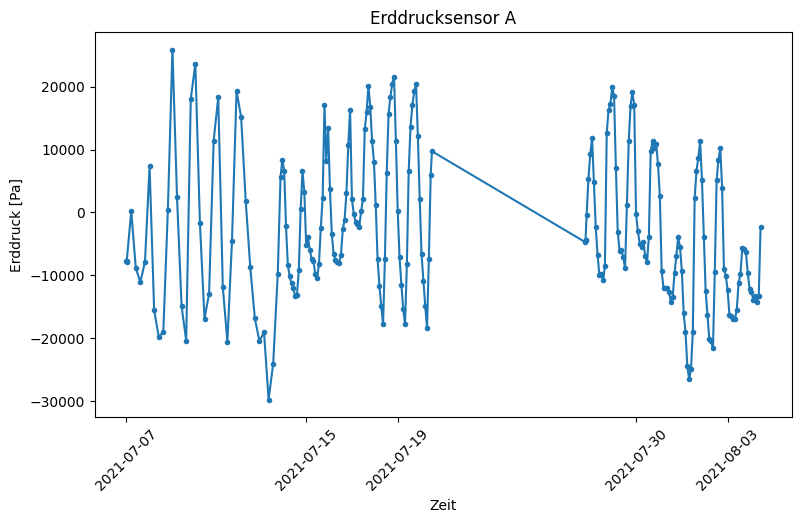

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor A')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSA[0:219], '.-')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

**Correlation with temperature**

Is the EDS data influenced by temperature? Let's investigate if there is any correlation. 

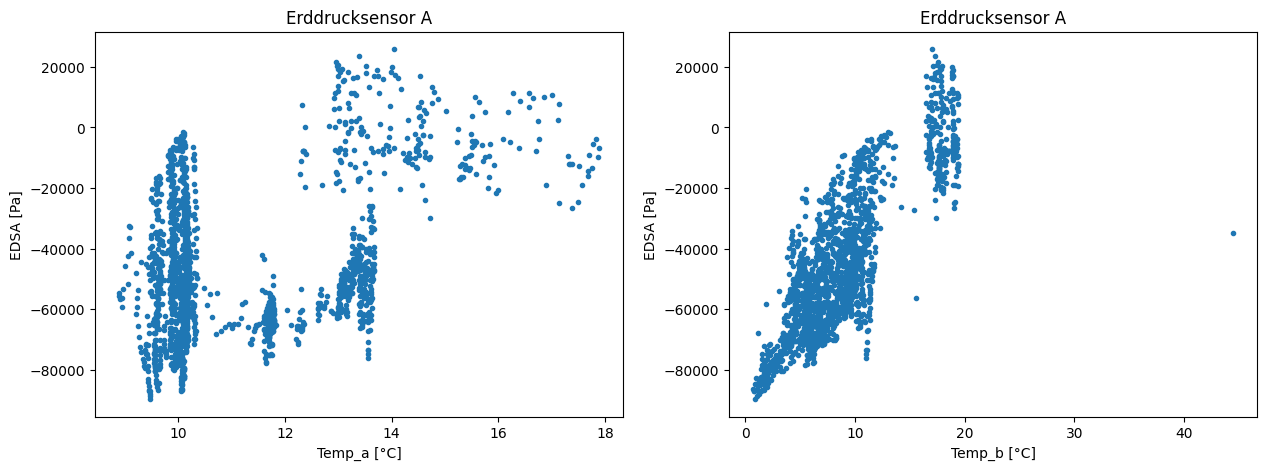

In [ ]:
# Temperature sensors on the sheet piles, Temp_a und Temp_b 

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.title('Erddrucksensor A')
plt.plot(df_catman.Tempa, df_catman.EDSA, '.')
plt.xlabel('Temp_a [°C]')
plt.ylabel('EDSA [Pa]')

plt.subplot(1,2,2)
plt.title('Erddrucksensor A')
plt.plot(df_catman.Tempb, df_catman.EDSA, '.')
plt.xlabel('Temp_b [°C]')
plt.ylabel('EDSA [Pa]')

plt.show()

# For Temp_a, a correlation cannot be recognised. 
# Temp_b shows some correlation. 

**Outside temperature**

The two following code blocks have been copied from, and are therefore identical to, '`05_catman.ipynb`'. 

In [ ]:
# compute temperature values for the same timestamps in df_catman, based on the data in df_klima


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Zeit_timestamp'] = df_catman.at[index, 'Zeit'].timestamp()

for index, row in df_klima.iterrows():
  df_klima.at[index, 'Aufnahmezeit_timestamp'] = df_klima.at[index, 'Aufnahmezeit'].timestamp()


def interpolate(my_timestamp, df, xcol, ycol):
  return np.interp([my_timestamp], df[xcol], df[ycol])


for index, row in df_catman.iterrows():
  df_catman.at[index, 'Temperatur aussen'] = interpolate(df_catman.at[index, 'Zeit_timestamp'], df_klima, 'Aufnahmezeit_timestamp', 'Temperatur')

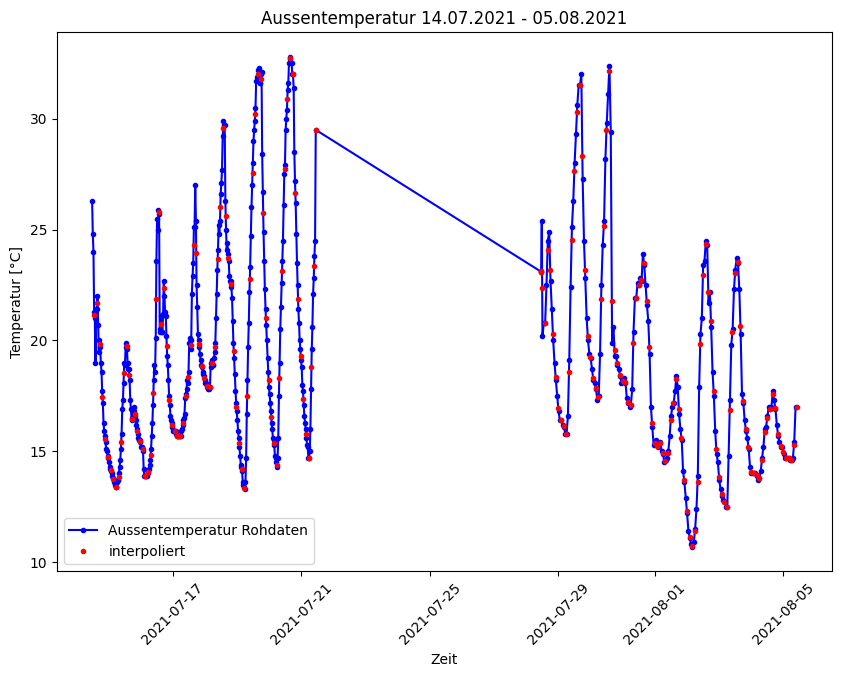

In [ ]:
# temperature effects 14.07.2021 - 05.08.2021

# df_klima: indexes 0 - 526 (included)
# df_catman: indexes 36 - 218 (included)

plt.figure(figsize=(10,7))
plt.title('Aussentemperatur 14.07.2021 - 05.08.2021')

plt.plot(df_klima.Aufnahmezeit[0:527], df_klima.Temperatur[0:527], 'b.-', label = 'Aussentemperatur Rohdaten')
plt.plot(df_catman.Zeit[36:219], df_catman['Temperatur aussen'][36:219], 'r.', label = 'interpoliert')
plt.tick_params(axis='x', rotation=45)
plt.xlabel('Zeit')
plt.ylabel('Temperatur [°C]')
plt.legend()
plt.show()

intercept: -68930.88358388018
slope: [3077.36121903]
R-squared: 0.924614921137541


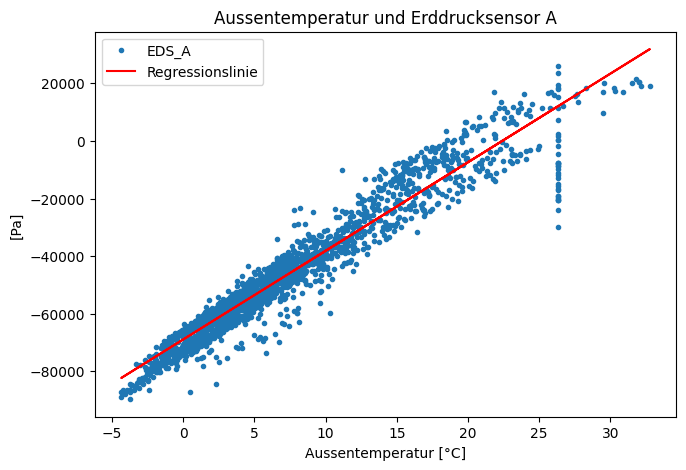

In [ ]:
# Temperature sensor for outside temperature

my_x = pd.DataFrame(df_catman['Temperatur aussen'])
my_y = df_catman.EDSA
regression_model = linear_model.LinearRegression()
regression_model.fit(X = my_x, y = my_y)

print('intercept: ' + str(regression_model.intercept_))
print('slope: ' + str(regression_model.coef_))
print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))

train_prediction = regression_model.predict(X = my_x)

# plot the results
plt.figure(figsize=(7.5,5))

plt.title('Aussentemperatur und Erddrucksensor A')

plt.plot(my_x, my_y, marker='.', linestyle='', label='EDS_A')
plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('[Pa]')
plt.legend()
plt.show()

# Yes, strong correlation. 
# The reader can check on his/her own that the points are not clustered 
# as a result of electricity supply interruptions. The phenomenon that 
# was observed with the strain gauges is therefore not present here with 
# the earth pressure cells.

### EDS_B

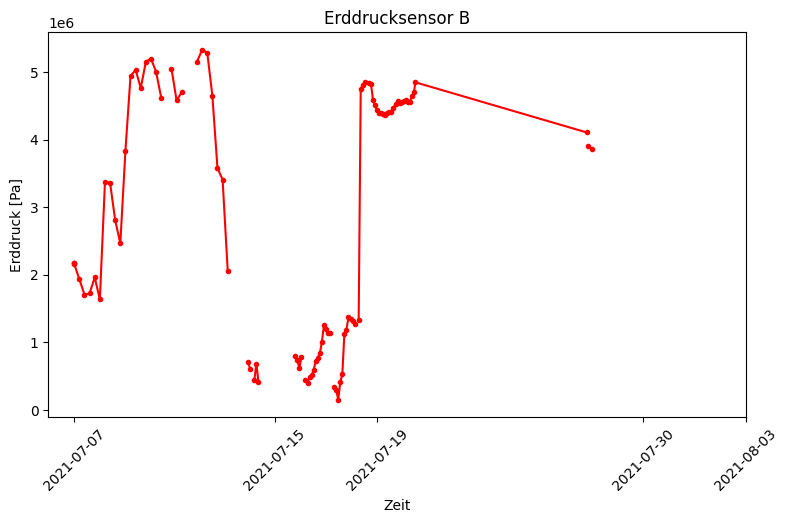

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor B')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSB[0:219], '.-', color='red')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

### EDS_B2

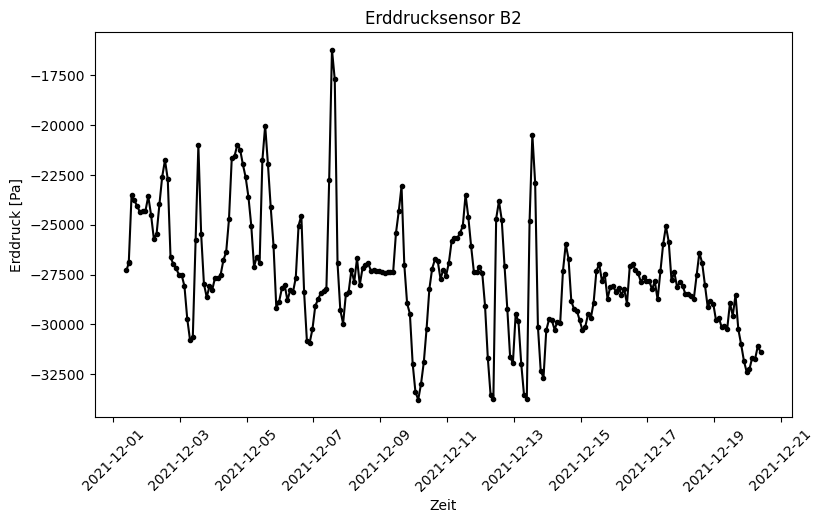

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor B2')

# time period from 01.12. - 20.12.2021
plt.plot(df_catman.Zeit[500:730], df_catman.EDSB2[500:730], '.-', color='black', label='01.12. - 20.12.2021')
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.tick_params(axis='x', rotation=45)
plt.show()

intercept: -30476.093108961213
slope: [1537.24514761]
R-squared: 0.9274417457141592


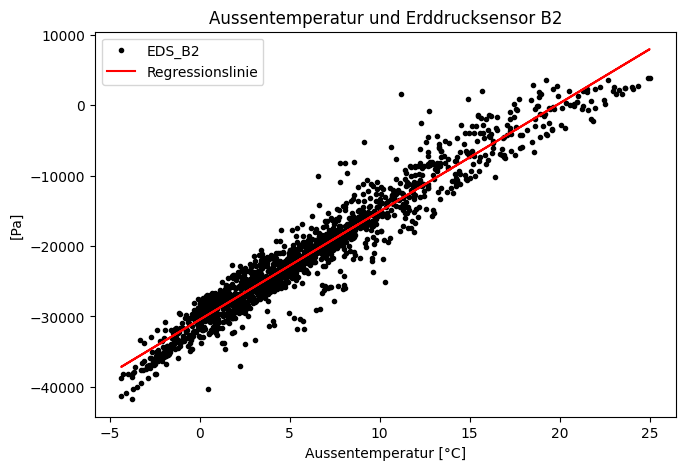

In [ ]:
# investigate the correlation with outside temperature

my_x = pd.DataFrame(df_catman['Temperatur aussen'][219:])
my_y = df_catman.EDSB2[219:]
regression_model = linear_model.LinearRegression()
regression_model.fit(X = my_x, y = my_y)

print('intercept: ' + str(regression_model.intercept_))
print('slope: ' + str(regression_model.coef_))
print('R-squared: ' + str(regression_model.score(X = my_x, y = my_y)))

train_prediction = regression_model.predict(X = my_x)

# plot the results
plt.figure(figsize=(7.5,5))

plt.title('Aussentemperatur und Erddrucksensor B2')

plt.plot(my_x, my_y, marker='.', color='black', linestyle='', label='EDS_B2')
plt.plot(my_x, train_prediction, color='red', label='Regressionslinie')
plt.xlabel('Aussentemperatur [°C]')
plt.ylabel('[Pa]')
plt.legend()
plt.show()

### EDS_C

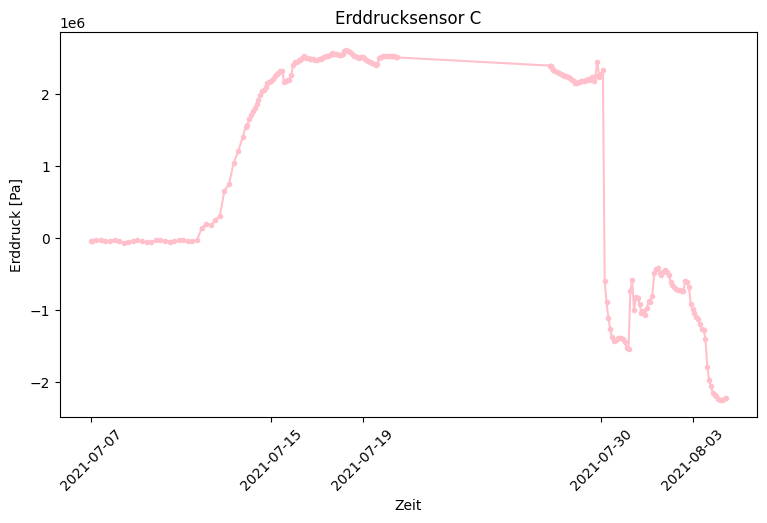

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor C')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSC[0:219], '.-', color='pink')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

### EDS_D
The earth pressure cell EDS_D didn't work from the very start, no data was collected. 

### EDS_E

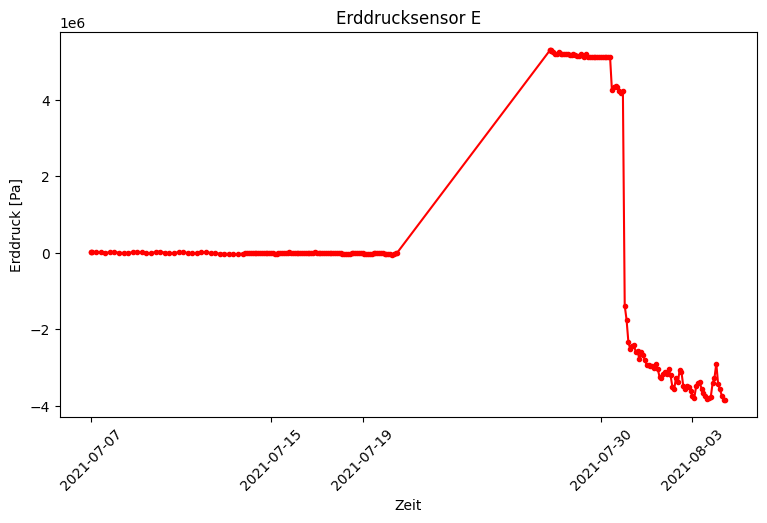

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor E')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSE[0:219], '.-', color='red')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

### EDS_F

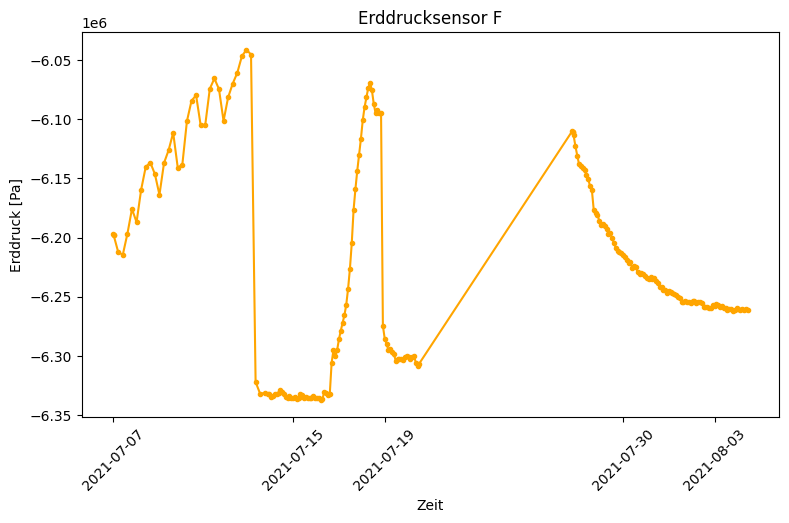

In [ ]:
plt.figure(figsize=(9,5))
plt.title('Erddrucksensor F')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSF[0:219], '.-', color='orange')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

### EDS_G

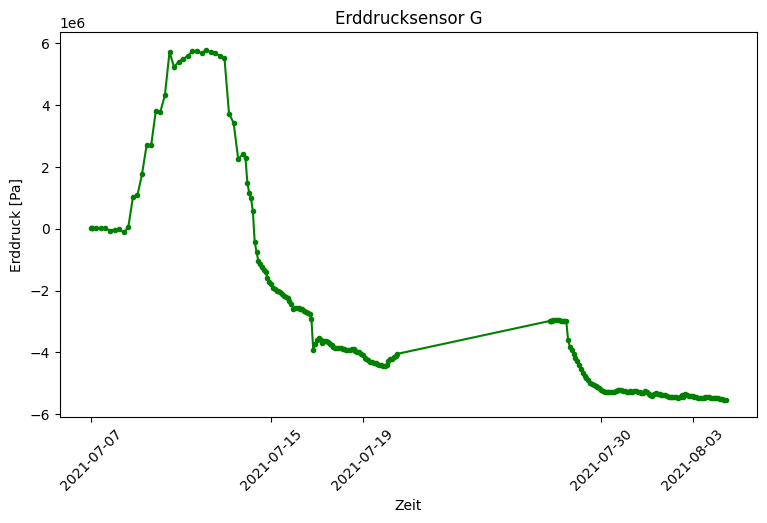

In [ ]:
# no NaN 

plt.figure(figsize=(9,5))
plt.title('Erddrucksensor G')

plt.plot(df_catman.Zeit[0:219], df_catman.EDSG[0:219], '.-', color='green')   # The first measurement period (07.07.2021 - 05.08.2021) is stored in rows 0 to 218 of the dataframe
plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')

plt.xticks(df_catman.Zeit[:219:50])
plt.tick_params(axis='x', rotation=45)
plt.show()

# The data looks like rubbish. No further investigation. 

## Temperature effects

For the earth pressure cells A and B2, let's make an attempt at compensating for the temperature effects and see if the data is usable. We attempt two different methods, one takes the average temperature over the entire monitoring periods as the reference temperature ($T_{avg}$), the other takes the temperature when the very first data point was collected ($T_{0}$). 

In [ ]:
# EDS_A

# save the data in new columns named EDSA_new_avg and EDSA_new_0 (instead of EDSA)
for index, row in df_catman.iterrows():
  a = 3077.36121903
  T_avg = round(df_catman['Temperatur aussen'].mean(), 2)
  T_0 = df_catman['Temperatur aussen'][0]
  df_catman.at[index, 'EDSA_new_avg'] = df_catman.at[index, 'EDSA'] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a
  df_catman.at[index, 'EDSA_new_0'] = df_catman.at[index, 'EDSA'] - (df_catman.at[index, 'Temperatur aussen'] - T_0)*a

In [ ]:
# EDS_B2

# save the data in new columns named EDSB2_new_avg and EDSB2_new_0 (instead of EDSB2)
for index, row in df_catman.iterrows():
  a = 1537.24514761
  T_avg = round(df_catman['Temperatur aussen'].mean(), 2)
  T_0 = df_catman['Temperatur aussen'][219]
  df_catman.at[index, 'EDSB2_new_avg'] = df_catman.at[index, 'EDSB2'] - (df_catman.at[index, 'Temperatur aussen'] - T_avg)*a
  df_catman.at[index, 'EDSB2_new_0'] = df_catman.at[index, 'EDSB2'] - (df_catman.at[index, 'Temperatur aussen'] - T_0)*a

In [ ]:
# downsampling to a weekly frequency
eds_cols = ['Zeit', 'EDSA', 'EDSA_new_avg', 'EDSA_new_0', 'EDSB2', 'EDSB2_new_avg', 'EDSB2_new_0']
df_eds = df_catman[eds_cols]

df_eds_downsample = df_eds.resample('W', on='Zeit').mean()

df_eds_downsample

# The dataframe below does not contain data from 15.08.2021 to 31.10.2021. 
# In fact, the file "rawdata_catman_Alpnachstad_messung_0-4_und_12-18.csv" 
# does not contain all raw data collected with Catman, but only measurements 
# 0 to 4 and 12 to 18 (5 to 11 not retrieved). 

,EDSA,EDSA_new_avg,EDSA_new_0,EDSB2,EDSB2_new_avg,EDSB2_new_0
Zeit,,,,,,
2021-07-11,-3181.447233,-60758.875641,-3181.447233,NaN,NaN,NaN
2021-07-18,-1795.344735,-40180.452429,17396.975979,NaN,NaN,NaN
2021-07-25,1052.203029,-44139.840972,13437.587436,NaN,NaN,NaN
2021-08-01,-778.706772,-39395.906462,18181.521946,NaN,NaN,NaN
2021-08-08,-9295.562535,-36332.051980,21245.376428,NaN,NaN,NaN
2021-08-15,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-22,NaN,NaN,NaN,NaN,NaN,NaN
2021-08-29,NaN,NaN,NaN,NaN,NaN,NaN
2021-09-05,NaN,NaN,NaN,NaN,NaN,NaN


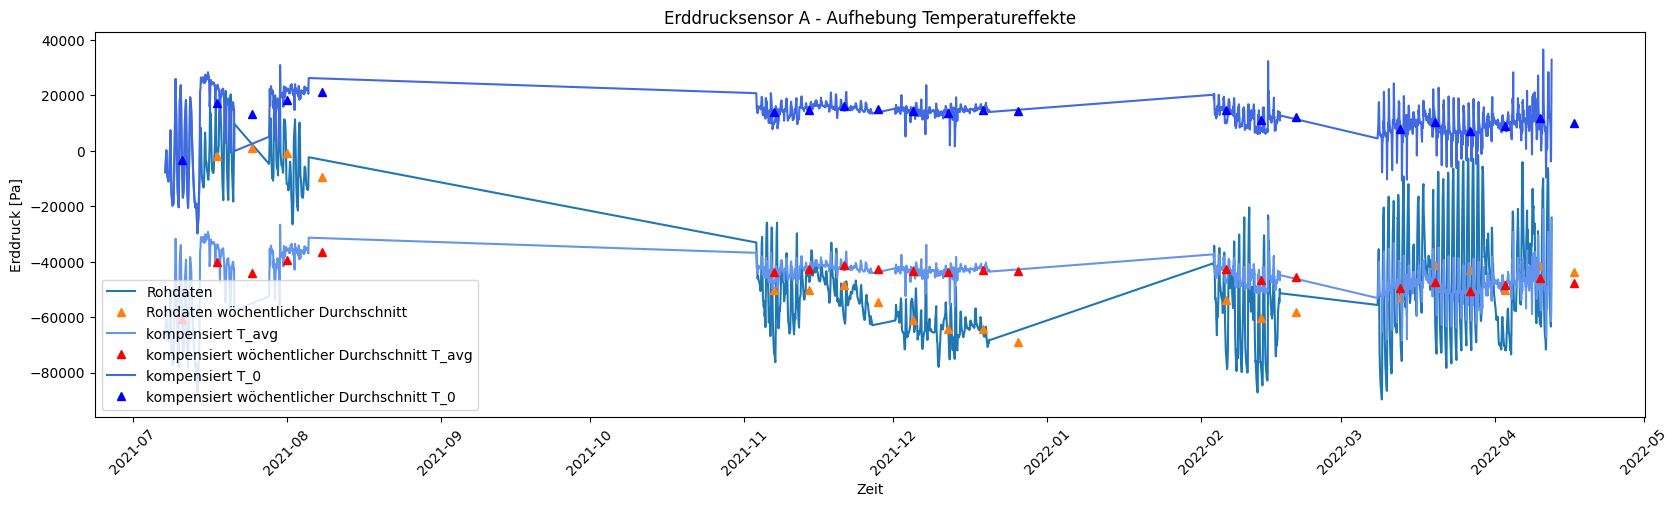

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor A - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSA, '-', label='Rohdaten')
plt.plot(df_eds_downsample.EDSA, '^', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_catman.Zeit, df_catman.EDSA_new_avg, '-', color='cornflowerblue', label='kompensiert T_avg')
plt.plot(df_eds_downsample.EDSA_new_avg, 'r^', label='kompensiert wöchentlicher Durchschnitt T_avg')

plt.plot(df_catman.Zeit, df_catman.EDSA_new_0, '-', color='royalblue', label='kompensiert T_0')
plt.plot(df_eds_downsample.EDSA_new_0, 'b^', label='kompensiert wöchentlicher Durchschnitt T_0')

plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()

# As it is known from the pre-processing of the strain gauges data, it's 
# impossible to completely eliminate the temperature effects. Nonetheless, the 
# variation has greatly diminished. 

# For the downsampled and temperature compensated data we have a plausible 
# order of magnitude (roughly -40 kPa) with relative small variance. 
# However, the sign remains negative. 

<ipython-input-32-aa1c15e3cdcd>:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r^" (-> color='r'). The keyword argument will take precedence.
  plt.plot(df_eds_downsample.EDSB2_new_avg, 'r^', color='limegreen', label='kompensiert wöchentlicher Durchschnitt T_avg')


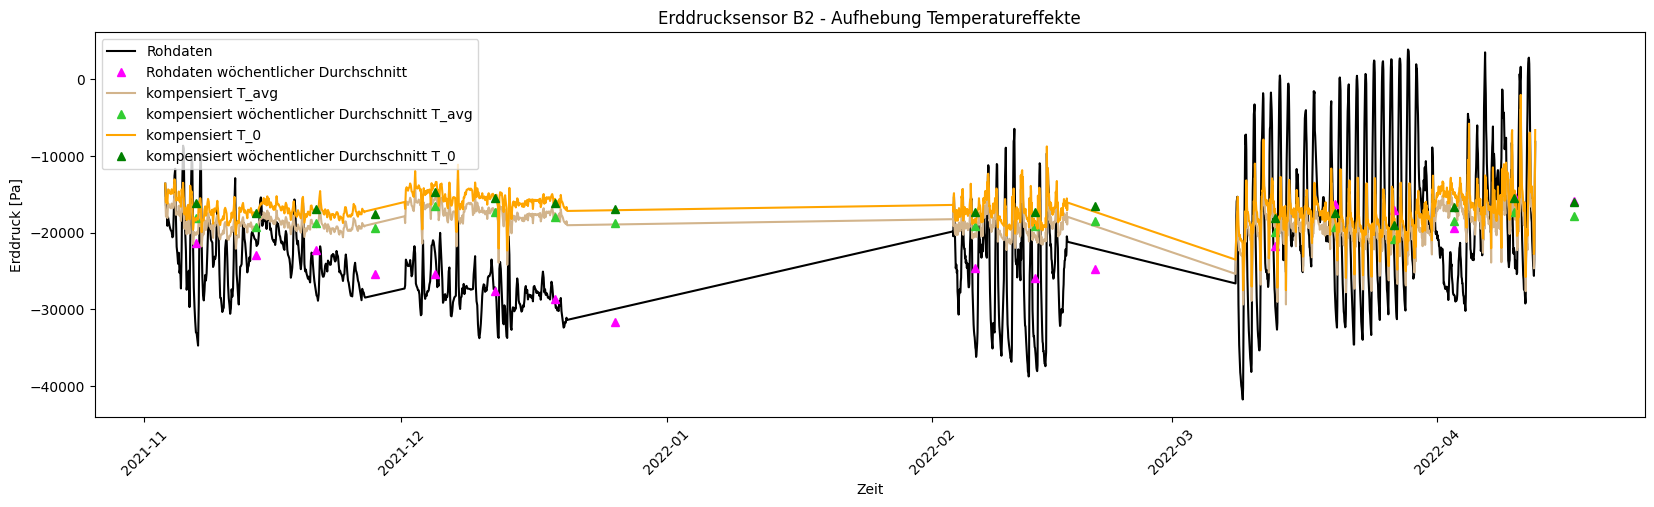

In [ ]:
plt.figure(figsize=(20,5))
plt.title('Erddrucksensor B2 - Aufhebung Temperatureffekte')

plt.plot(df_catman.Zeit, df_catman.EDSB2, '-', color='black', label='Rohdaten')
plt.plot(df_eds_downsample.EDSB2, '^', color='magenta', label='Rohdaten wöchentlicher Durchschnitt')
plt.plot(df_catman.Zeit, df_catman.EDSB2_new_avg, '-', color='tan', label='kompensiert T_avg')
plt.plot(df_eds_downsample.EDSB2_new_avg, 'r^', color='limegreen', label='kompensiert wöchentlicher Durchschnitt T_avg')

plt.plot(df_catman.Zeit, df_catman.EDSB2_new_0, '-', color='orange', label='kompensiert T_0')
plt.plot(df_eds_downsample.EDSB2_new_0, '^', color='green', label='kompensiert wöchentlicher Durchschnitt T_0')

plt.xlabel('Zeit')
plt.ylabel('Erddruck [Pa]')
plt.legend()
plt.tick_params(axis='x', rotation=45)
plt.show()

# Same as above. 

## Compare empirical data with expectations


In [ ]:
# Compare the values of two measuring periods: November (baseline) and April (end of construction works)

# month of November 
df_winter = df_eds_downsample[(df_eds_downsample.index >= datetime(2021, 11, 1))]
df_winter = df_winter[(df_winter.index <= datetime(2021, 11, 30))]
mean_winter = pd.Series(round(df_winter.mean()), name='mean November 2021')

# month of April
df_spring = df_eds_downsample[(df_eds_downsample.index >= datetime(2022, 4, 1))]
mean_spring = pd.Series(round(df_spring.mean()), name='mean April 2022')



delta = pd.Series(dtype='float')

for col in df_winter.columns:
  delta[col] = round(df_spring[col].mean() - df_winter[col].mean())

delta = pd.Series(delta, name='difference [Pa]: ')
df_evaluation = pd.DataFrame(data=[mean_winter, mean_spring, delta])
df_evaluation

,EDSA,EDSA_new_avg,EDSA_new_0,EDSB2,EDSB2_new_avg,EDSB2_new_0
mean November 2021,-50762.0,-42524.0,15053.0,-22972.0,-18857.0,-16997.0
mean April 2022,-45142.0,-47351.0,10227.0,-16816.0,-17919.0,-16059.0
difference [Pa]:,5620.0,-4826.0,-4826.0,6156.0,938.0,938.0


As a baseline for sensor EDS_A, we expect values between 7.5 and 10 kPa:

$\sigma_v = 1.0 m * \gamma = 15 - 20 kPa$

$e_0 = K_0 * \sigma_v = 0.5 * (15 - 20 kPa) = 7.5 - 10 kPa$

The empirical baseline as to 'EDSA_new_0' matches pretty well with our expectations. 

After the excavation, the pressures should drop to zero as the earth pressure cell is exposed to the air by the excavation works. However, the values drop by only about 30%.

As a baseline for sensor EDS_B2, we expect values between 20 and 27 kPa:

$\sigma_v = 2.7 m * \gamma = 40.5 - 54 kPa$

$e_0 = K_0 * \sigma_v = 0.5 * (40.5 - 54 kPa) = 20 - 27 kPa$

The difference between 'EDSB2_new_avg' and 'EDSB2_new_0' is minimal. The absolute value of the empirical baseline is slightly low (17-19 kN) but not completely off. However the sign is negative, meaning we have suction instead of pressure! This doesn't make any sense. 

Furthermore, we expect a pressure reduction after the excavation works, as the soil stresses change from rest (K0) to active (Ka). The empirical data show an increase of pressure. This doesn't make any sense either. 

## Compare empirical data with Plaxis simulations

In this section we consider the data from earth pressure cell EDS_B2 only. 

First, we look at the active pressures on the wall from a simulation in Plaxis 2D with $\beta_{D} = 1.0$. We compare two construction stages: 

*   Phase 1: installation of sheet piles into the ground
*   Phase 4: excavation work completed and groundwater table lowered (final stage) 


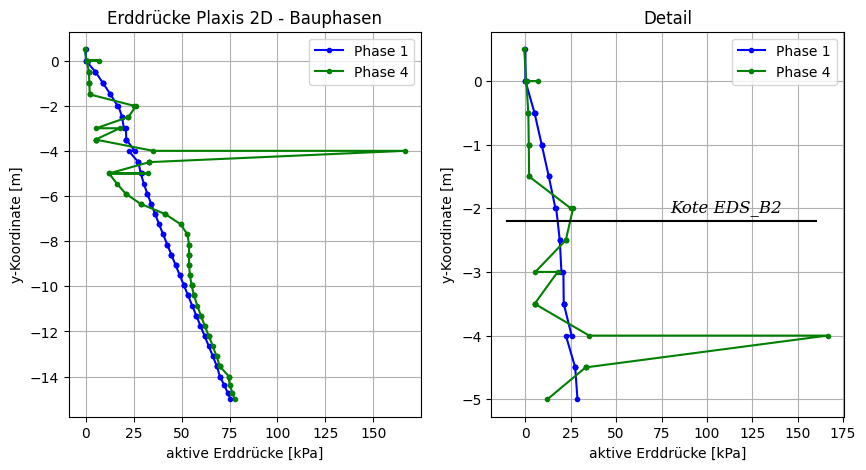

In [ ]:
# compare the active earth pressures in the 1st and 4th construction stage 

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Erddrücke Plaxis 2D - Bauphasen')
plt.plot(-df_bauphasen['Phase_1_[kN/m2]_10'], df_bauphasen['Y_coordinate_[m]_10'], '.-', color='blue', label='Phase 1')
plt.plot(-df_bauphasen['Phase_4_[kN/m2]_10'], df_bauphasen['Y_coordinate_[m]_10'], '.-', color='green', label='Phase 4')
plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.subplot(1,2,2)
plt.title('Detail')
plt.plot(-df_bauphasen['Phase_1_[kN/m2]_10'][0:35], df_bauphasen['Y_coordinate_[m]_10'][0:35], '.-', color='blue', label='Phase 1')
plt.plot(-df_bauphasen['Phase_4_[kN/m2]_10'][0:35], df_bauphasen['Y_coordinate_[m]_10'][0:35], '.-', color='green', label='Phase 4')
font_elsupply = {'family': 'serif', 'color': 'black' , 'size': 12, 'style': 'italic'}
plt.text(80, -2.05, 'Kote EDS_B2', fontdict=font_elsupply)
plt.plot([-10, 160], [-2.2, -2.2], '-', color='black')
plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.show()

# According to the Plaxis simulations, the sensor EDS_B2 should register a moderate increase in earth pressure (ca. 5 kPa).
# Before temperature compensation an increase of 6.2 kPa was recorded. It matches very well with the trend we observe in Plaxis :) 
# After the temperature compensation the increase was merely 0.9 kPa. 

Second, we look at how big of an influence the reduction factors $\beta_{D}$ have on the earth pressure. 

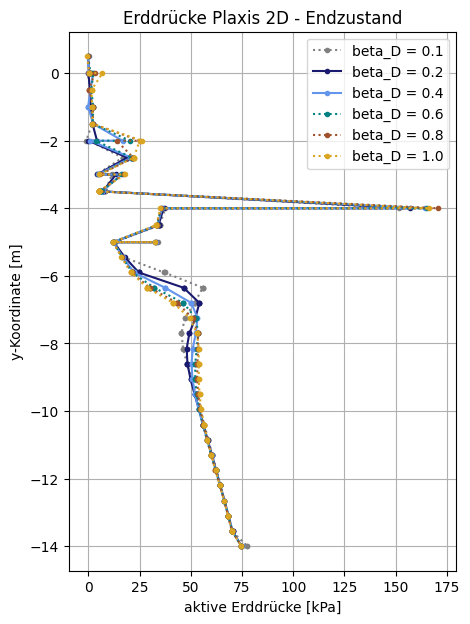

In [ ]:
plt.figure(figsize=(5,7))

plt.title('Erddrücke Plaxis 2D - Endzustand')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_01'], df_erddruck['Y_coordinate_[m]_01'], '.:', color='gray', label='beta_D = 0.1')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_02'], df_erddruck['Y_coordinate_[m]_02'], '.-', color='midnightblue', label='beta_D = 0.2')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_04'], df_erddruck['Y_coordinate_[m]_04'], '.-', color='cornflowerblue', label='beta_D = 0.4')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_06'], df_erddruck['Y_coordinate_[m]_06'], '.:', color='teal', label='beta_D = 0.6')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_08'], df_erddruck['Y_coordinate_[m]_08'], '.:', color='sienna', label='beta_D = 0.8')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_10'], df_erddruck['Y_coordinate_[m]_10'], '.:', color='goldenrod', label='beta_D = 1.0')

plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.show()

# Some differences at a depth of around 2m and 6-9 m.

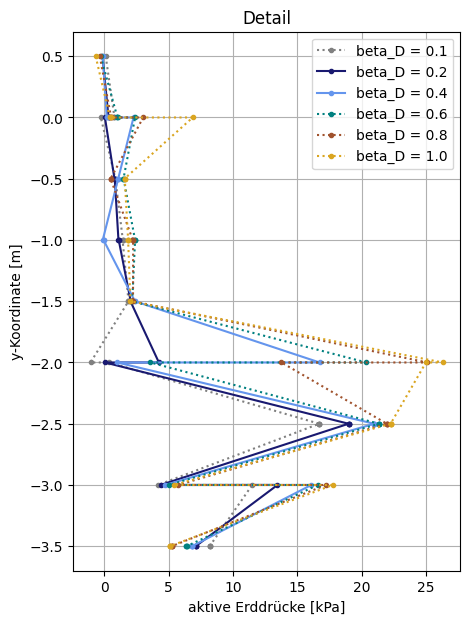

In [ ]:
# same figure as above, but only up to a depth of 3.5m. 
plt.figure(figsize=(5,7))

plt.title('Detail')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_01'][0:25], df_erddruck['Y_coordinate_[m]_01'][0:25], '.:', color='gray', label='beta_D = 0.1')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_02'][0:25], df_erddruck['Y_coordinate_[m]_02'][0:25], '.-', color='midnightblue', label='beta_D = 0.2')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_04'][0:25], df_erddruck['Y_coordinate_[m]_04'][0:25], '.-', color='cornflowerblue', label='beta_D = 0.4')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_06'][0:25], df_erddruck['Y_coordinate_[m]_06'][0:25], '.:', color='teal', label='beta_D = 0.6')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_08'][0:25], df_erddruck['Y_coordinate_[m]_08'][0:25], '.:', color='sienna', label='beta_D = 0.8')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_10'][0:25], df_erddruck['Y_coordinate_[m]_10'][0:25], '.:', color='goldenrod', label='beta_D = 1.0')

plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.show()

Third, we compare the empirical data from EDS_B2 with the results obtained from Plaxis simulations with $\beta_{D} = 0.2$ and $\beta_{D} = 0.4$, respectively. As it is explained in '`08_plaxis_polynomial.ipynb`', the estimated correction factor for single piles is in fact $0.2 - 0.3$.

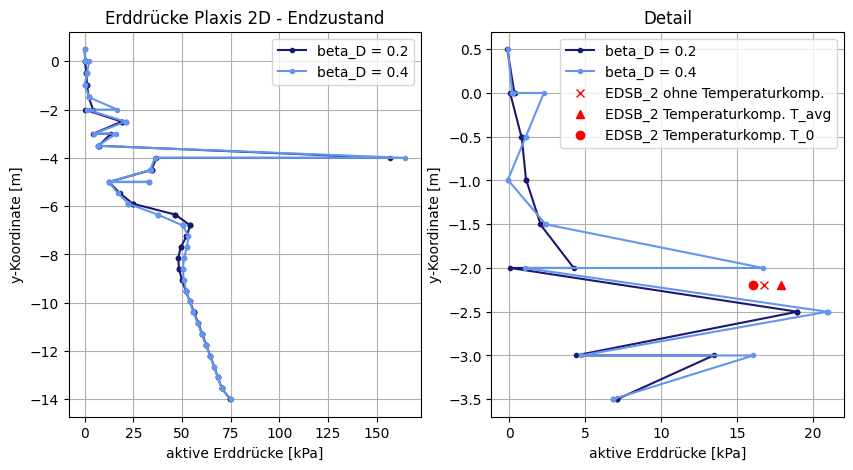

In [ ]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.title('Erddrücke Plaxis 2D - Endzustand')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_02'], df_erddruck['Y_coordinate_[m]_02'], '.-', color='midnightblue', label='beta_D = 0.2')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_04'], df_erddruck['Y_coordinate_[m]_04'], '.-', color='cornflowerblue', label='beta_D = 0.4')
plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.subplot(1,2,2)
plt.title('Detail')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_02'][0:25], df_erddruck['Y_coordinate_[m]_02'][0:25], '.-', color='midnightblue', label='beta_D = 0.2')
plt.plot(-df_erddruck['Phase_4_[kN/m2]_04'][0:25], df_erddruck['Y_coordinate_[m]_04'][0:25], '.-', color='cornflowerblue', label='beta_D = 0.4')

plt.plot(-df_evaluation.loc['mean April 2022', 'EDSB2']/1000, -2.2, 'x', color='red', label='EDSB_2 ohne Temperaturkomp.')
plt.plot(-df_evaluation.loc['mean April 2022', 'EDSB2_new_avg']/1000, -2.2, '^', color='red', label='EDSB_2 Temperaturkomp. T_avg')
plt.plot(-df_evaluation.loc['mean April 2022', 'EDSB2_new_0']/1000, -2.2, 'o', color='red', label='EDSB_2 Temperaturkomp. T_0')

plt.xlabel('aktive Erddrücke [kPa]')
plt.ylabel('y-Koordinate [m]')
plt.grid(visible=True, which='major', axis='both')
plt.legend()

plt.show()

# The empirical measurements (in red) refer to the average of April 2022, that 
# is, long after the excavation works in front of the instrumented section were
# concluded. The different kinds of temperature compensation are represented. 
# The order of magnitude of the data collected with EDS_B2 matches our 
# expectations. However, please note that the sign of the measurements from 
# EDS_B2 was inverted!

## Summary

The EDS do dot seem to deliver any insight into the earth pressures acting on the steel sheet piles:

*   EDS_B, EDS_C, EDS_D, EDS_E, EDS_F, and EDS_G: the data looks nonsensical. 

*   EDS_A and EDS_B2 show the same pattern as the strain gauges with respect to temperature effects. Also in this case these effects cannot be fully canceled out. The collected data allows for a first, rough verification of the order of magnitude of the earth pressures, respectively a rough validation of the Plaxis model. Some problems remain (sign is wrong, trends do not quite match our expectations, ...), meaning the data from the earth pressure cells cannot be exploited for a detailed analysis.